# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from matplotlib import rcParams

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from keras.models import Sequential
from keras.layers import Dense

# Some preprocessing

In [2]:
data = pd.read_csv("./collected_data/prepared_data/diff_step_data.csv")
data.head()

,vertices_dif,redexes_dif,heights_dif,widths_dif,redex_depths,redex_indexes,steps_time,strategy_name
0,3,1,0,1,4,12,131224,LI
1,23,1,7,10,5,27,187277,LI
2,20,1,5,8,1,1,32085,LI
3,3,0,-1,1,7,10,179030,LI
4,3,1,2,1,11,16,179197,LI


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   vertices_dif   3931 non-null   int64 
 1   redexes_dif    3931 non-null   int64 
 2   heights_dif    3931 non-null   int64 
 3   widths_dif     3931 non-null   int64 
 4   redex_depths   3931 non-null   int64 
 5   redex_indexes  3931 non-null   int64 
 6   steps_time     3931 non-null   int64 
 7   strategy_name  3931 non-null   object
dtypes: int64(7), object(1)
memory usage: 245.8+ KB


In [5]:
pca = PCA(2, random_state=42)
data_pca = pca.fit_transform(data[['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif',
                                   'redex_depths']])

C:\Users\voldo\AppData\Local\Temp\ipykernel_23664\2351182786.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")


<AxesSubplot: >

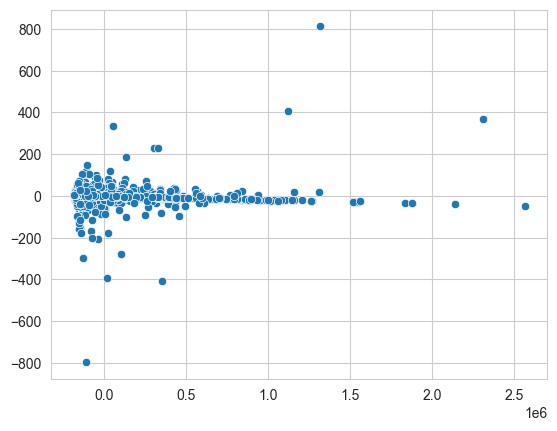

In [6]:
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")

<AxesSubplot: >

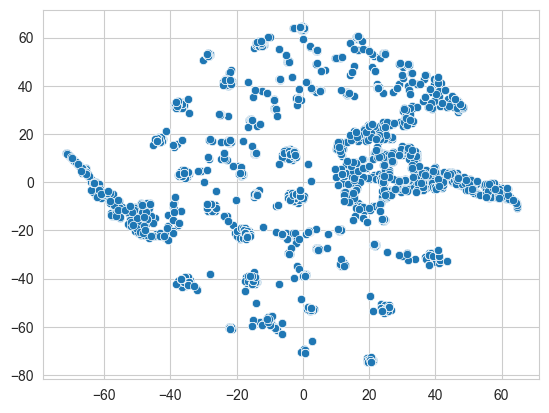

In [9]:
tsne = TSNE(random_state=3)
tsne_feature = tsne.fit_transform(data[['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif',
                                   'redex_depths']])
sns.scatterplot(x=tsne_feature[:, 0], y=tsne_feature[:, 1])

## Check skewed features

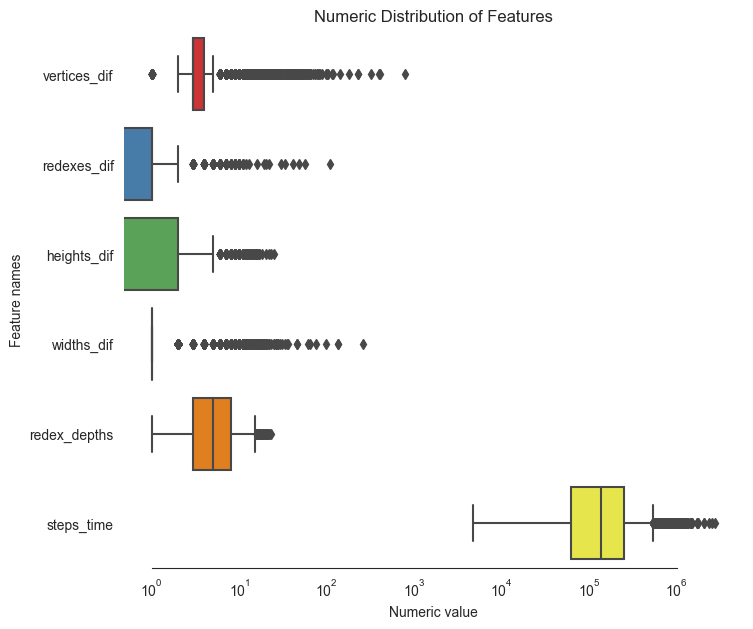

In [12]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=data[['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif',
                            'redex_depths', 'steps_time']],
                 orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric value")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [13]:
# Find skewed numerical features
skew_features = data[['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif',
                      'redex_depths', 'steps_time']].apply(
    lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f"There are {high_skew.shape[0]} numerical features with skew > 0.5: ")
skewness = pd.DataFrame({"skew": skew_features})
skewness.head(10)

There are 6 numerical features with skew > 0.5: 


,skew
steps_time,3.692667
heights_dif,2.967291
redex_depths,1.034103
redexes_dif,0.872391
widths_dif,0.836359
vertices_dif,0.717888


array([[<AxesSubplot: title={'center': 'vertices_dif'}>,
        <AxesSubplot: title={'center': 'redexes_dif'}>,
        <AxesSubplot: title={'center': 'heights_dif'}>],
       [<AxesSubplot: title={'center': 'widths_dif'}>,
        <AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'redex_indexes'}>],
       [<AxesSubplot: title={'center': 'steps_time'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

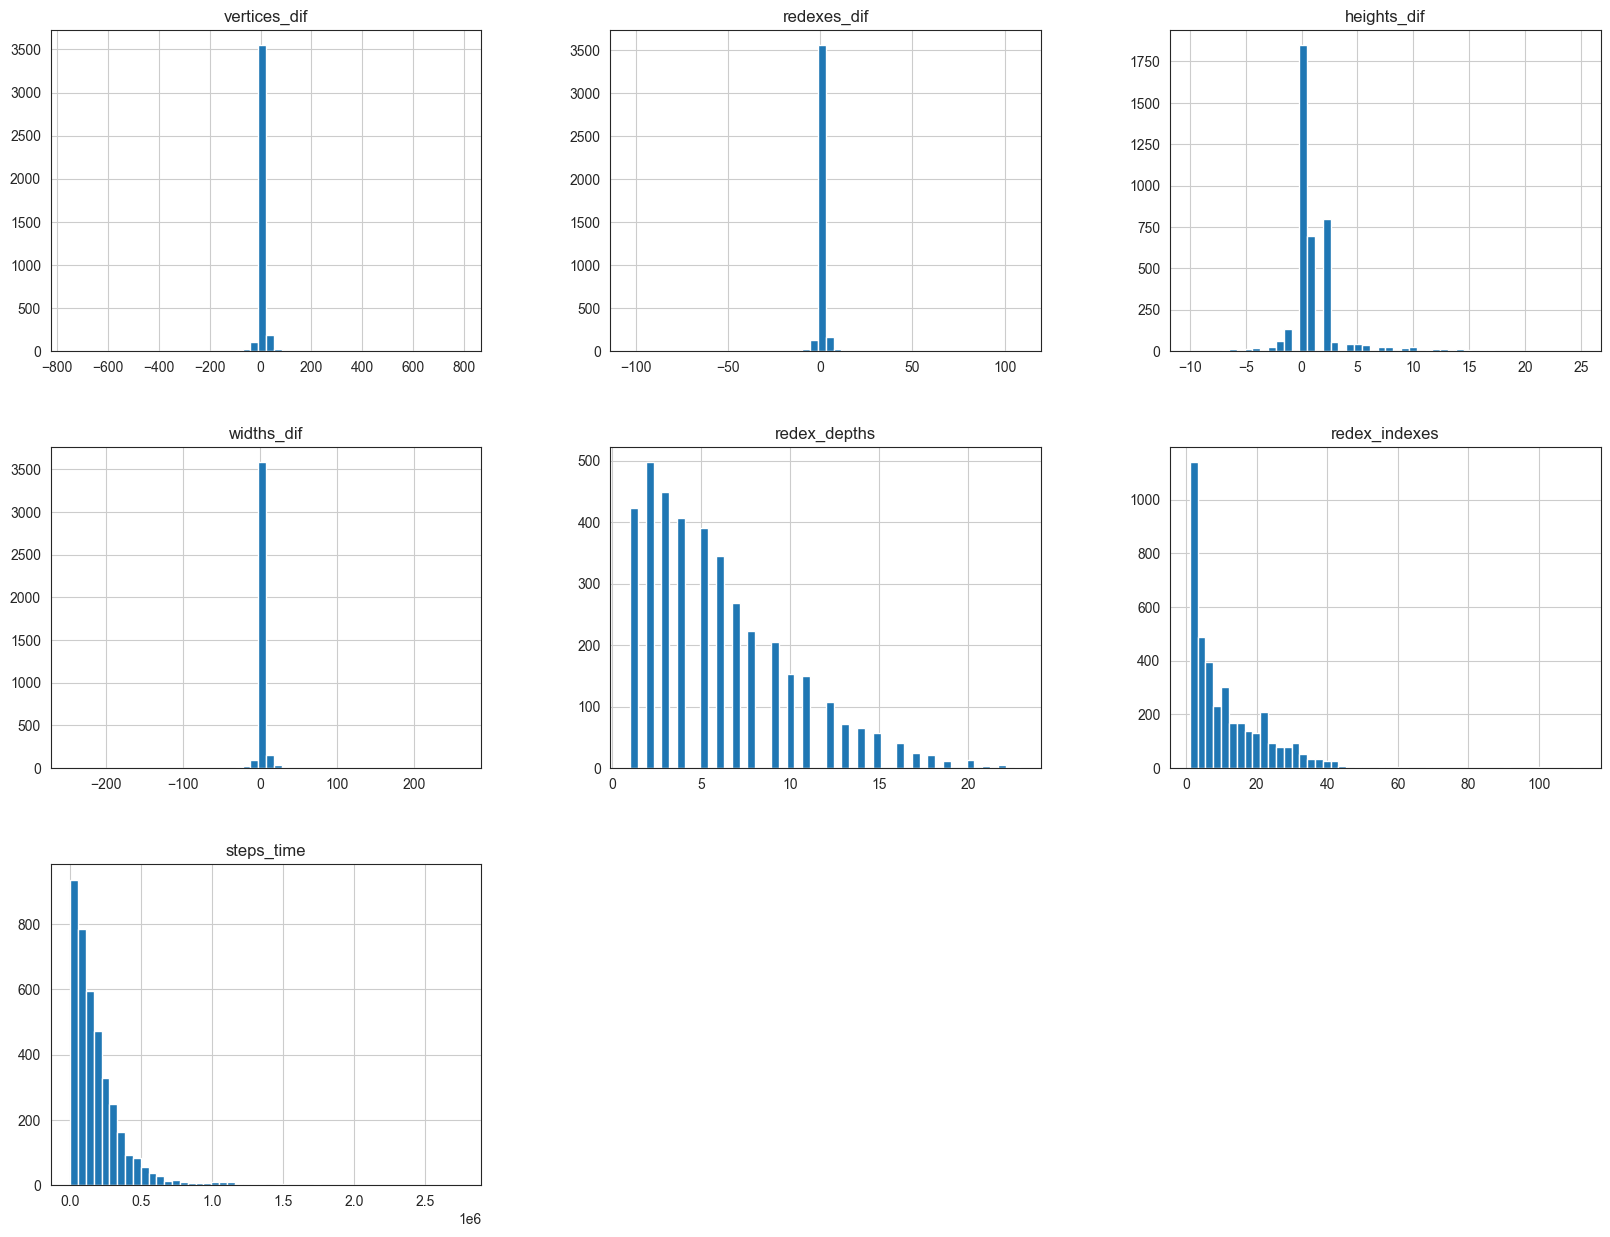

In [14]:
rcParams['figure.figsize'] = 20, 15
data.hist(bins=50)

array([[<AxesSubplot: title={'center': 'vertices_dif'}>,
        <AxesSubplot: title={'center': 'redexes_dif'}>],
       [<AxesSubplot: title={'center': 'heights_dif'}>,
        <AxesSubplot: title={'center': 'widths_dif'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'steps_time'}>]], dtype=object)

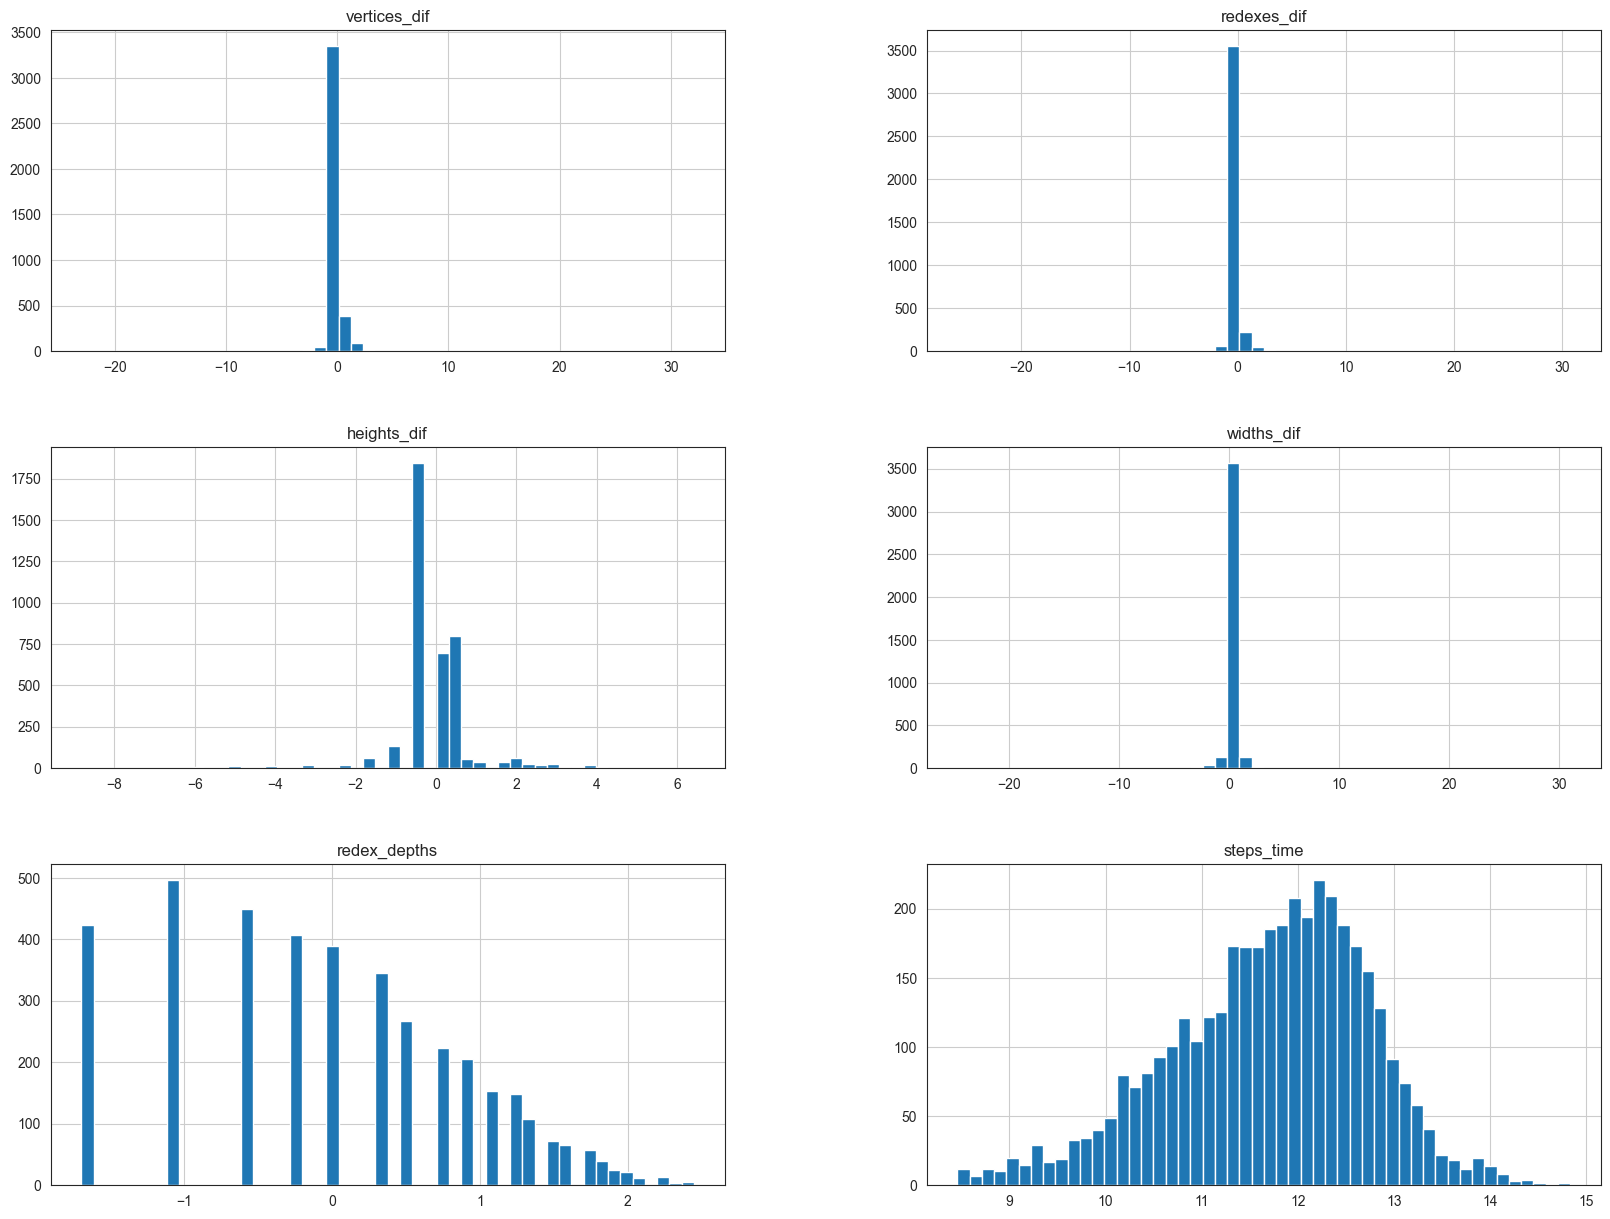

In [23]:
data_bc = pd.DataFrame()
power_trans = PowerTransformer(method='yeo-johnson')

for col_name in ['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif',
                  'redex_depths']:
    norm_col_data = power_trans.fit_transform(np.array(data[col_name]).reshape(-1, 1))
    data_bc[col_name] = list(norm_col_data.reshape(1, -1)[0])

data_bc['steps_time'] = np.log(data['steps_time'])

data_bc.hist(bins=50)

In [24]:
data_for_training = data_bc.copy(deep=True)

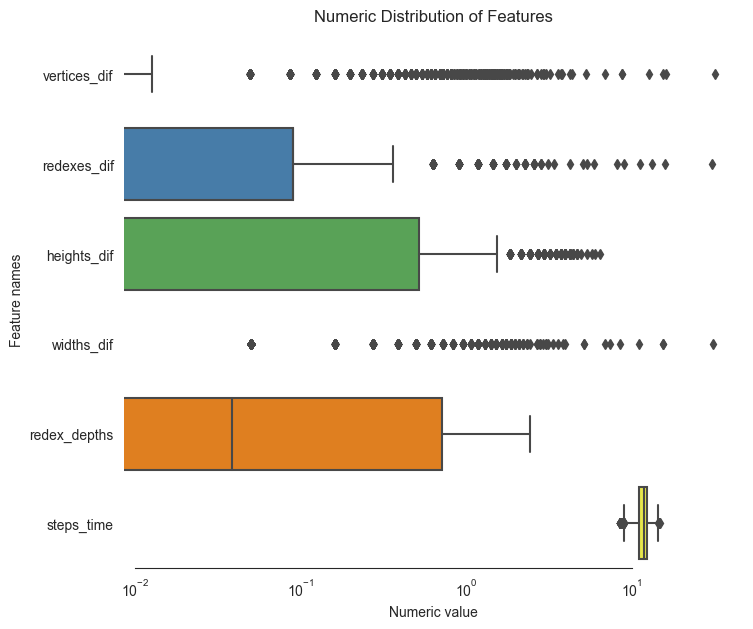

In [25]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=data_for_training,
                 orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric value")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [27]:
# Find skewed numerical features
skew_features = data_for_training.apply(
    lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f"There are {high_skew.shape[0]} numerical features with skew > 0.5: ")
skewness = pd.DataFrame({"skew": skew_features})
skewness.head(10)

There are 3 numerical features with skew > 0.5: 


,skew
vertices_dif,6.961615
widths_dif,4.773497
redexes_dif,3.675670
redex_depths,-0.012930
heights_dif,-0.315280
steps_time,-0.440934


In [28]:
def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2726
Examples for testing 1205


In [29]:
x_train, y_train = train_ds.drop('steps_time', axis=1), train_ds[["steps_time"]]
x_test, y_test = test_ds.drop('steps_time', axis=1), test_ds[["steps_time"]]

In [30]:
x_data, y_data = data_for_training.drop('steps_time', axis=1), data_for_training[["steps_time"]]

# Functions for drawing predicted values

In [31]:
rcParams['figure.figsize'] = 10, 12


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

# I. USING Yeo-Johnson Normalized Data

## 1. Linear Regression

In [32]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 0.6353272118644461
TEST Root Mean Squared Error(RMSE): 0.6232794433322384


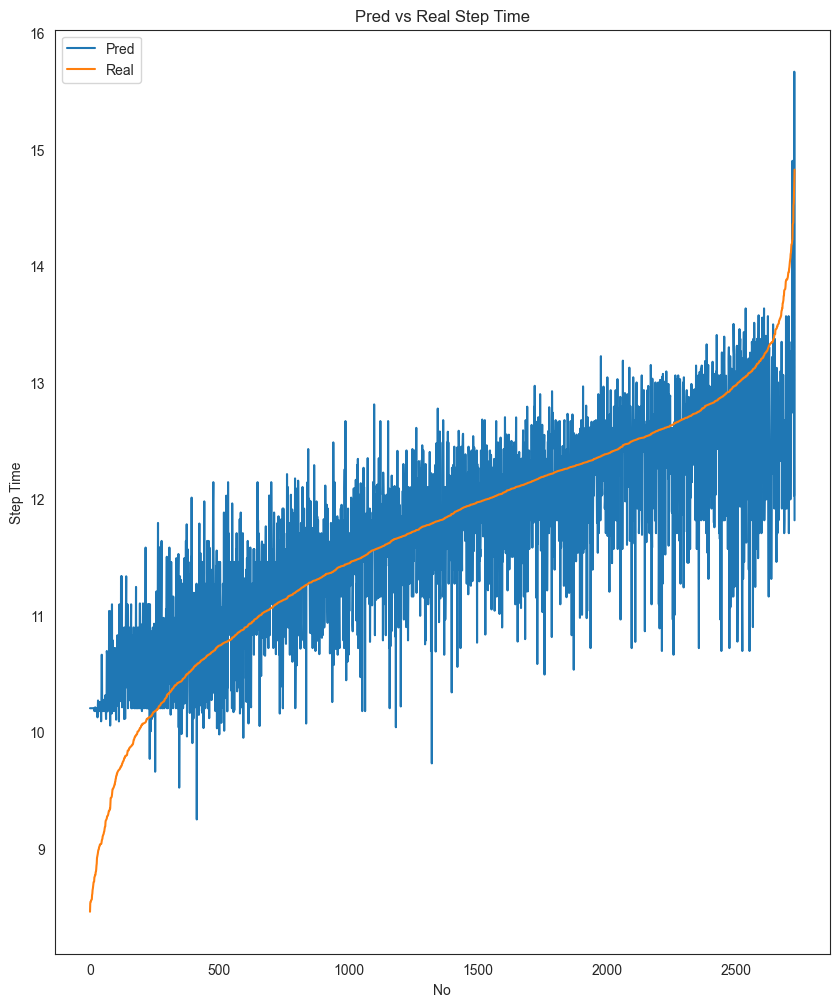

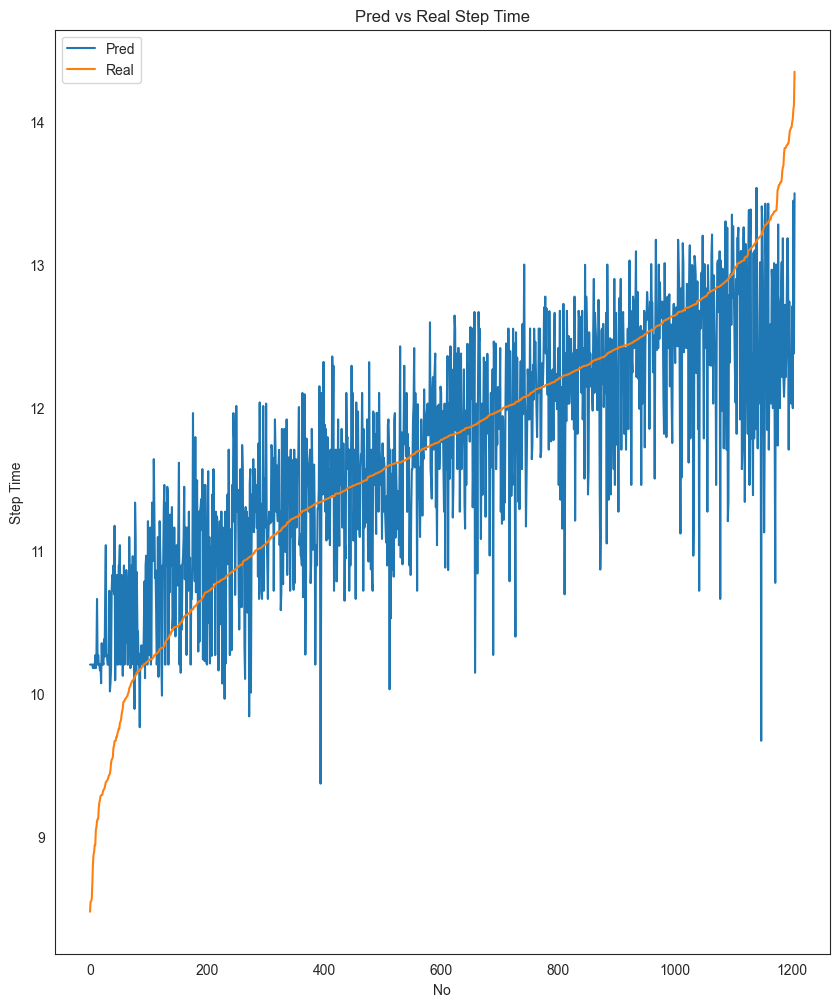

In [33]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [34]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 0.6315349371096951


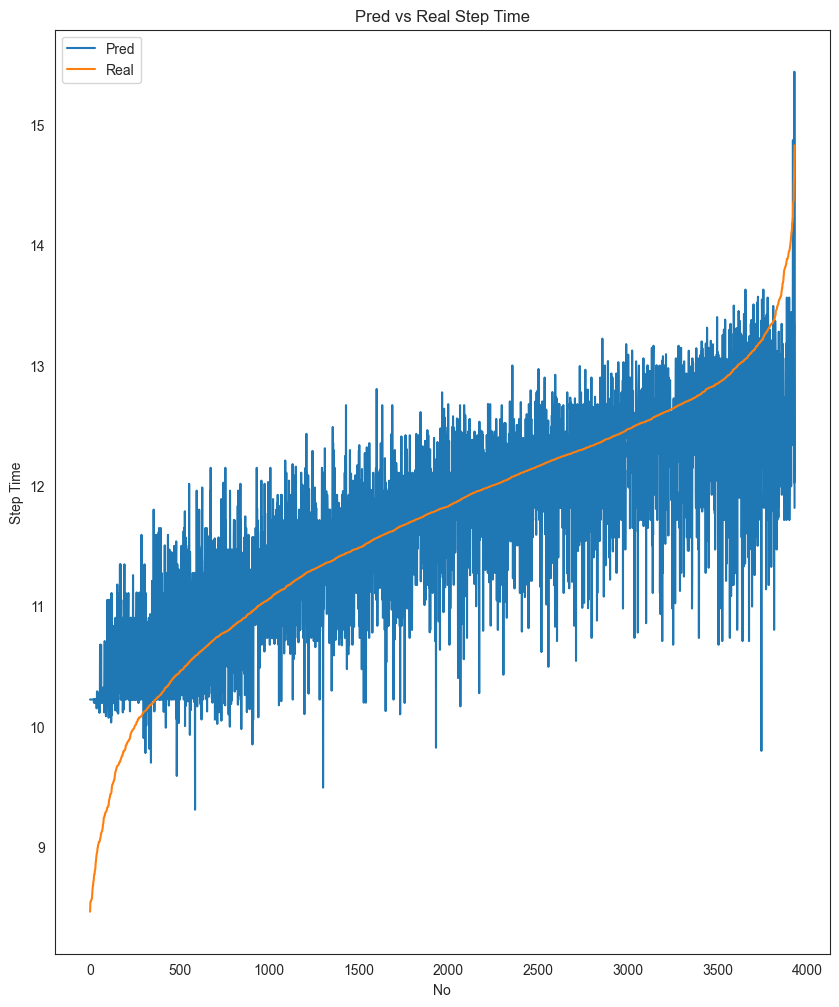

In [35]:
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

## 2. ANN Regression

In [36]:
rcParams["figure.figsize"] = 7, 5

In [41]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=300)

Epoch 1/150
10/10 [==============================] - 0s 14ms/step - loss: 126.9863 - val_loss: 125.9257
Epoch 2/150
10/10 [==============================] - 0s 4ms/step - loss: 125.1900 - val_loss: 124.4267
Epoch 3/150
10/10 [==============================] - 0s 5ms/step - loss: 123.7635 - val_loss: 123.0720
Epoch 4/150
10/10 [==============================] - 0s 5ms/step - loss: 122.4505 - val_loss: 121.7604
Epoch 5/150
10/10 [==============================] - 0s 4ms/step - loss: 121.1470 - val_loss: 120.4146
Epoch 6/150
10/10 [==============================] - 0s 4ms/step - loss: 119.8159 - val_loss: 119.0579
Epoch 7/150
10/10 [==============================] - 0s 5ms/step - loss: 118.4727 - val_loss: 117.6642
Epoch 8/150
10/10 [==============================] - 0s 4ms/step - loss: 117.1101 - val_loss: 116.2643
Epoch 9/150
10/10 [==============================] - 0s 4ms/step - loss: 115.7451 - val_loss: 114.8704
Epoch 10/150
10/10 [==============================] - 0s 4ms/step - loss

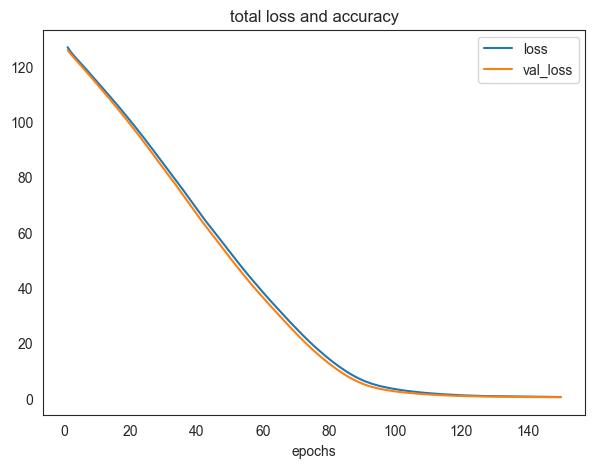

In [42]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [43]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)

123/123 [==============================] - 0s 742us/step
TRAIN Root Mean Squared Error(RMSE): 0.7000672617338003
TEST Root Mean Squared Error(RMSE): 0.6531914370214477
ALL RMSE: 0.6860385648750135


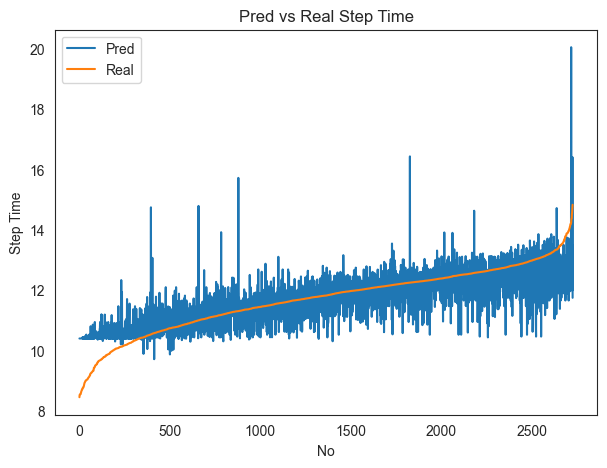

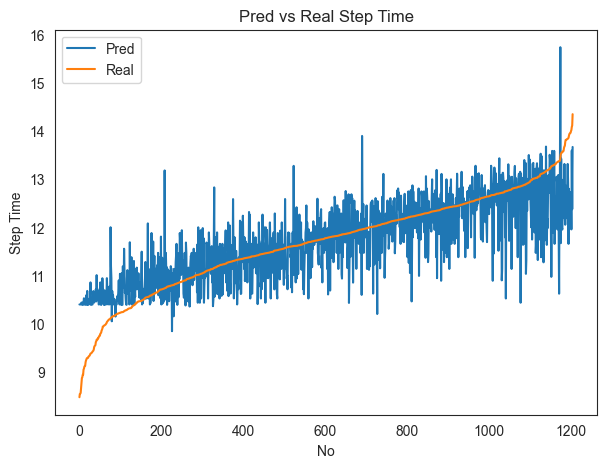

In [44]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [47]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=1)

Epoch 1/5
2726/2726 [==============================] - 4s 1ms/step - loss: 56.2873 - val_loss: 9.8706
Epoch 2/5
2726/2726 [==============================] - 3s 1ms/step - loss: 16.7334 - val_loss: 3.4968
Epoch 3/5
2726/2726 [==============================] - 3s 1ms/step - loss: 5.6718 - val_loss: 1.5011
Epoch 4/5
2726/2726 [==============================] - 3s 1ms/step - loss: 3.7346 - val_loss: 1.2376
Epoch 5/5
2726/2726 [==============================] - 3s 1ms/step - loss: 3.3794 - val_loss: 1.1586


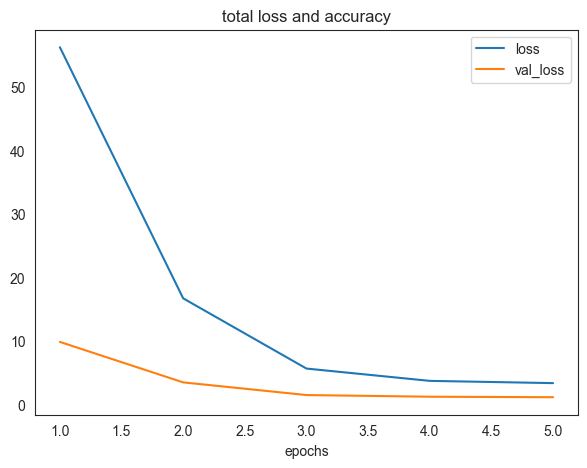

In [48]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 693us/step
TRAIN Root Mean Squared Error(RMSE): 1.7294426204548357
TEST Root Mean Squared Error(RMSE): 1.0763942320621096
ALL RMSE: 1.5586173734697417


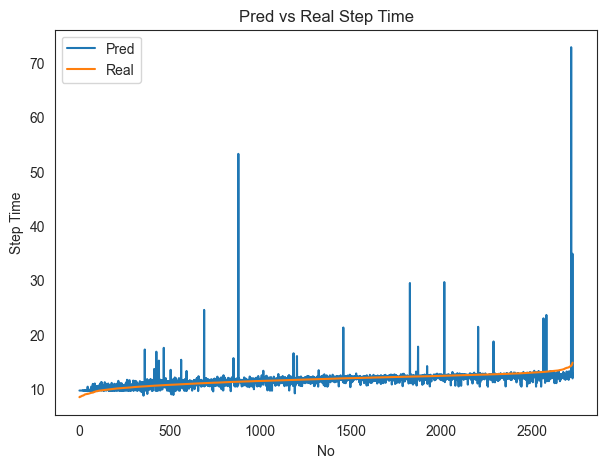

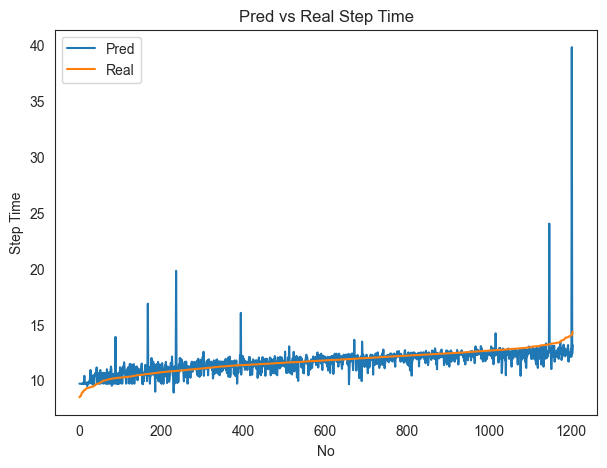

In [49]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [51]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2726/2726 [==============================] - 4s 1ms/step - loss: 28.4005 - val_loss: 1.9400
Epoch 2/20
2726/2726 [==============================] - 3s 1ms/step - loss: 2.4900 - val_loss: 0.7972
Epoch 3/20
2726/2726 [==============================] - 3s 1ms/step - loss: 1.8365 - val_loss: 0.8912
Epoch 4/20
2726/2726 [==============================] - 3s 1ms/step - loss: 1.7210 - val_loss: 0.6087
Epoch 5/20
2726/2726 [==============================] - 3s 1ms/step - loss: 1.6723 - val_loss: 0.6591
Epoch 6/20
2726/2726 [==============================] - 3s 1ms/step - loss: 1.3960 - val_loss: 0.5515
Epoch 7/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.9799 - val_loss: 0.4891
Epoch 8/20
2726/2726 [==============================] - 3s 1ms/step - loss: 1.0184 - val_loss: 0.4473
Epoch 9/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.8212 - val_loss: 0.5047
Epoch 10/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.74

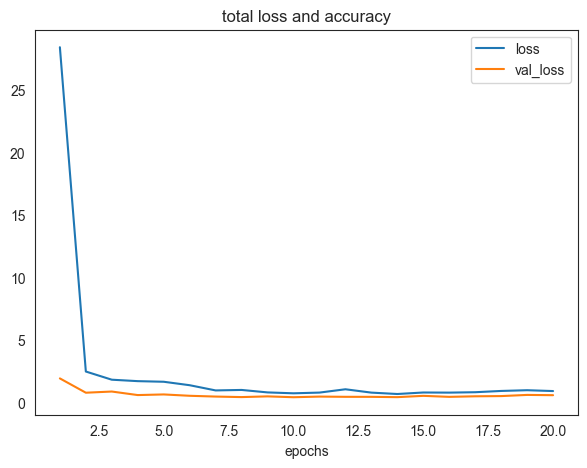

In [52]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 730us/step
TRAIN Root Mean Squared Error(RMSE): 1.0522690505285481
TEST Root Mean Squared Error(RMSE): 0.7741659632209993
ALL RMSE: 0.9754835675445458


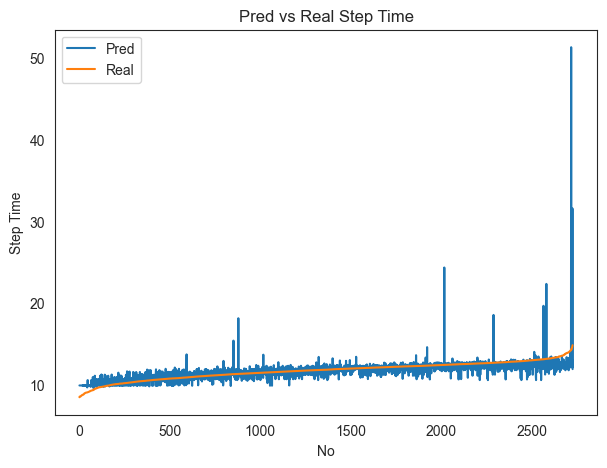

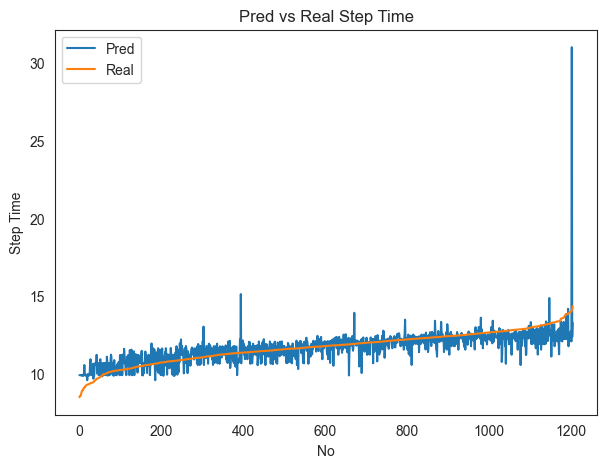

In [53]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [54]:
model = Sequential()
model.add(Dense(units=30, activation='relu', input_dim=5))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=10, activation='relu' ))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2726/2726 [==============================] - 4s 1ms/step - loss: 20.3820 - val_loss: 1.2779
Epoch 2/20
2726/2726 [==============================] - 4s 1ms/step - loss: 2.6439 - val_loss: 0.5693
Epoch 3/20
2726/2726 [==============================] - 3s 1ms/step - loss: 1.2770 - val_loss: 0.4300
Epoch 4/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.9545 - val_loss: 0.4584
Epoch 5/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.7356 - val_loss: 0.5702
Epoch 6/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.5951 - val_loss: 0.4312
Epoch 7/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.5247 - val_loss: 0.3440
Epoch 8/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.4715 - val_loss: 0.3397
Epoch 9/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.4328 - val_loss: 0.3465
Epoch 10/20
2726/2726 [==============================] - 3s 1ms/step - loss: 0.50

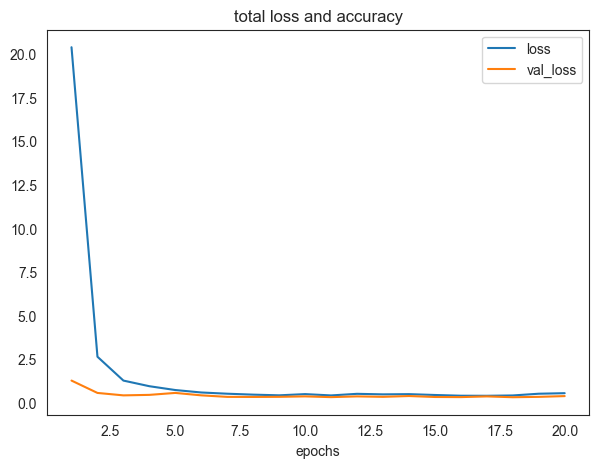

In [55]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 901us/step
TRAIN Root Mean Squared Error(RMSE): 0.6724541706990101
TEST Root Mean Squared Error(RMSE): 0.6233965756972035
ALL RMSE: 0.657805154798372


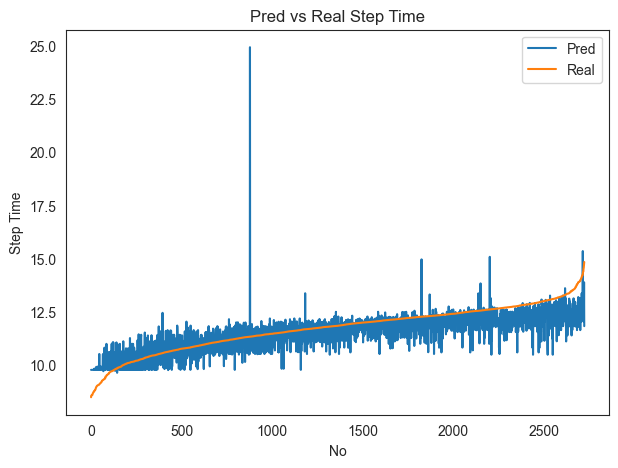

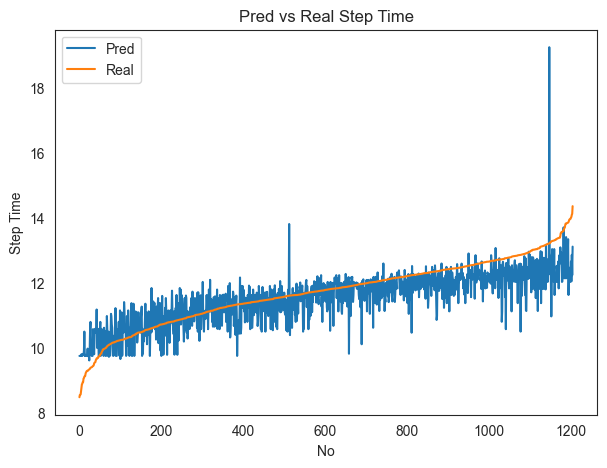

In [56]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# Test on original diff data

In [57]:
data_for_training = data[data_for_training.columns]
data_for_training['steps_time'] = data_bc['steps_time']

def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")
x_train, y_train = train_ds.drop('steps_time', axis=1), train_ds[["steps_time"]]
x_test, y_test = test_ds.drop('steps_time', axis=1), test_ds[["steps_time"]]
x_data, y_data = data_for_training.drop('steps_time', axis=1), data_for_training[["steps_time"]]

Examples for training 2747
Examples for testing 1184


C:\Users\voldo\AppData\Local\Temp\ipykernel_23664\4065355896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_training['steps_time'] = data_bc['steps_time']


## 1. Linear Regression

TRAIN Root Mean Squared Error(RMSE): 0.7231989366757487
TEST Root Mean Squared Error(RMSE): 0.7138265368105126


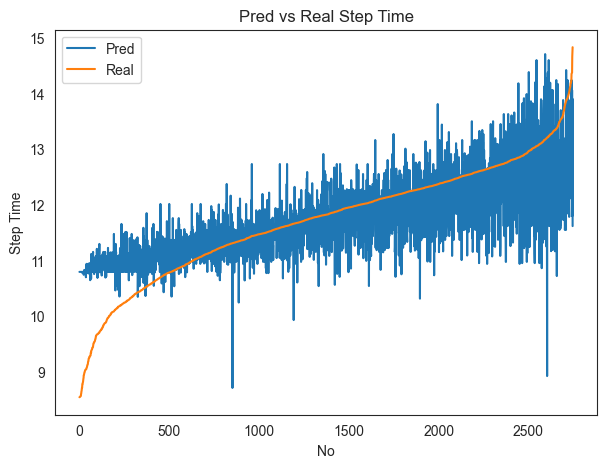

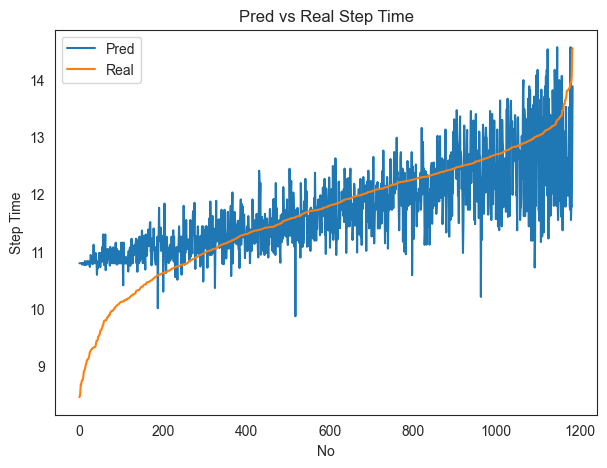

In [59]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

ALL RMSE: 0.7198711186082558


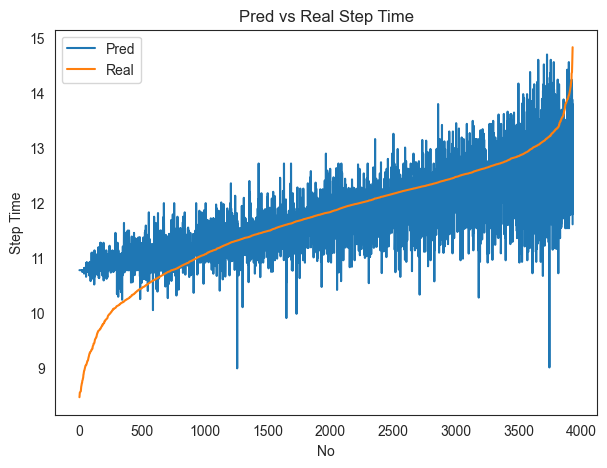

In [58]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

## 2. ANN Regression

In [60]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2747/2747 [==============================] - 4s 1ms/step - loss: 76.7791 - val_loss: 27.0654
Epoch 2/20
2747/2747 [==============================] - 3s 1ms/step - loss: 15.6357 - val_loss: 7.4827
Epoch 3/20
2747/2747 [==============================] - 3s 1ms/step - loss: 7.8384 - val_loss: 6.2271
Epoch 4/20
2747/2747 [==============================] - 3s 1ms/step - loss: 3.8284 - val_loss: 5.1264
Epoch 5/20
2747/2747 [==============================] - 3s 1ms/step - loss: 5.2732 - val_loss: 1.3406
Epoch 6/20
2747/2747 [==============================] - 4s 1ms/step - loss: 4.8511 - val_loss: 1.7372
Epoch 7/20
2747/2747 [==============================] - 3s 1ms/step - loss: 1.9400 - val_loss: 2.3888
Epoch 8/20
2747/2747 [==============================] - 3s 1ms/step - loss: 5.4835 - val_loss: 1.9853
Epoch 9/20
2747/2747 [==============================] - 3s 1ms/step - loss: 4.1019 - val_loss: 2.7942
Epoch 10/20
2747/2747 [==============================] - 3s 1ms/step - loss: 2.

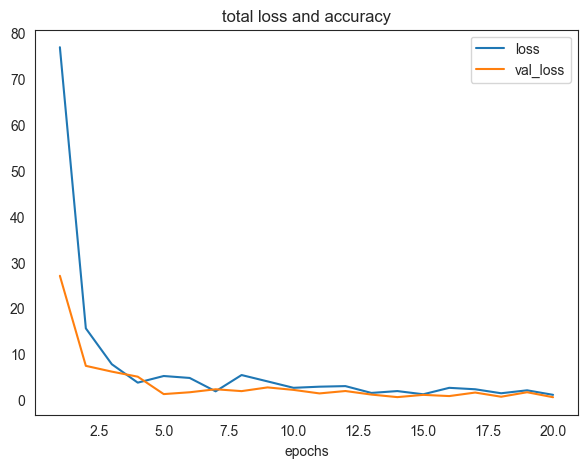

In [61]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 757us/step
TRAIN Root Mean Squared Error(RMSE): 0.8962763219214629
TEST Root Mean Squared Error(RMSE): 0.812136051119835
ALL RMSE: 0.8717886674944839


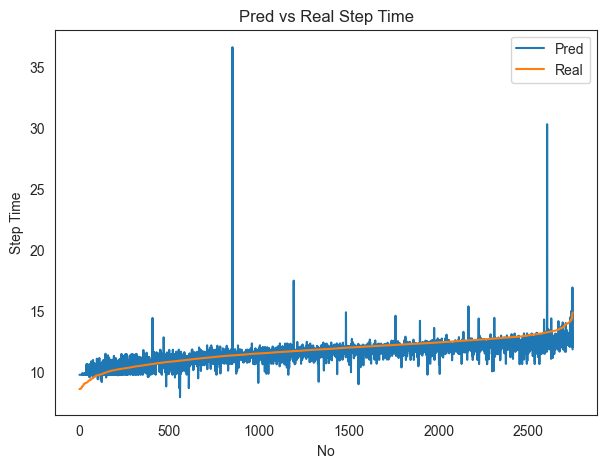

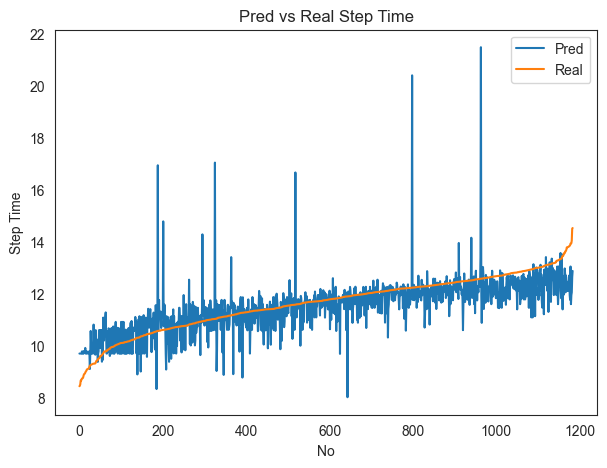

In [62]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# ABS Data + Yeo-Johnson Norm

array([[<AxesSubplot: title={'center': 'vertices_dif'}>,
        <AxesSubplot: title={'center': 'redexes_dif'}>],
       [<AxesSubplot: title={'center': 'heights_dif'}>,
        <AxesSubplot: title={'center': 'widths_dif'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'steps_time'}>]], dtype=object)

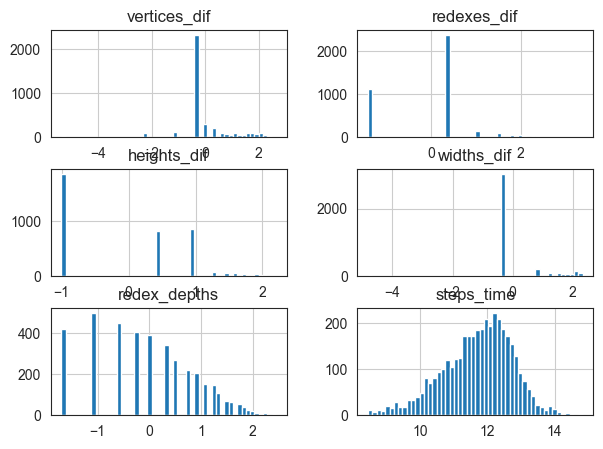

In [64]:
data_bc = pd.DataFrame()
power_trans = PowerTransformer(method='yeo-johnson')

for col_name in ['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif',
                  'redex_depths']:
    norm_col_data = np.array(np.abs(data[col_name]))
    norm_col_data = power_trans.fit_transform(norm_col_data.reshape(-1, 1))
    data_bc[col_name] = list(norm_col_data.reshape(1, -1)[0])

data_bc['steps_time'] = np.log(data['steps_time'])

data_bc.hist(bins=50)

In [65]:
data_for_training = data_bc

def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")
x_train, y_train = train_ds.drop('steps_time', axis=1), train_ds[["steps_time"]]
x_test, y_test = test_ds.drop('steps_time', axis=1), test_ds[["steps_time"]]
x_data, y_data = data_for_training.drop('steps_time', axis=1), data_for_training[["steps_time"]]

Examples for training 2798
Examples for testing 1133


## 1. Linear Regression

TRAIN Root Mean Squared Error(RMSE): 0.6294613006915335
TEST Root Mean Squared Error(RMSE): 0.6403853566453848


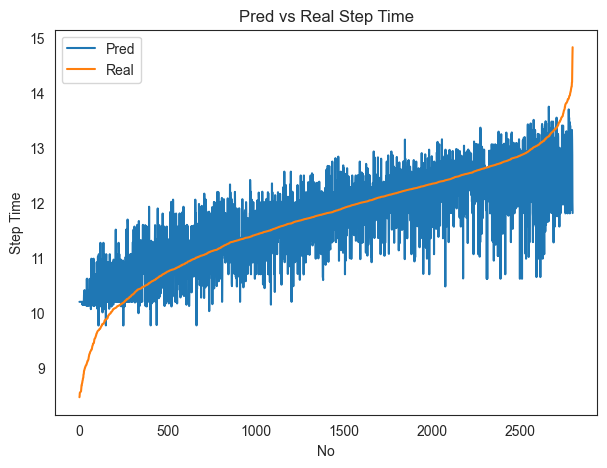

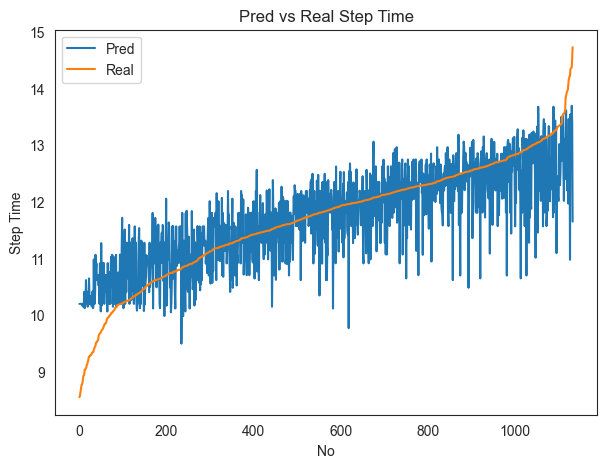

In [66]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

ALL RMSE: 0.6321805346000882


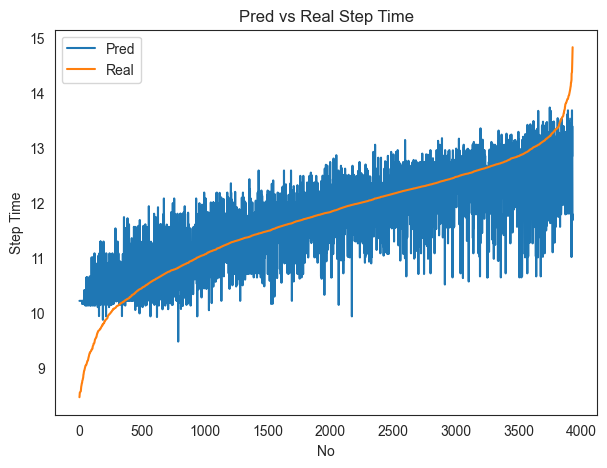

In [67]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

## 2. ANN Regression

In [68]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2798/2798 [==============================] - 3s 1ms/step - loss: 22.8549 - val_loss: 1.4977
Epoch 2/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.7452 - val_loss: 0.4450
Epoch 3/20
2798/2798 [==============================] - 4s 1ms/step - loss: 0.4122 - val_loss: 0.4350
Epoch 4/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.3870 - val_loss: 0.4271
Epoch 5/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.3705 - val_loss: 0.3706
Epoch 6/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.3696 - val_loss: 0.3574
Epoch 7/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.3615 - val_loss: 0.3638
Epoch 8/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.3584 - val_loss: 0.3692
Epoch 9/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.3588 - val_loss: 0.3650
Epoch 10/20
2798/2798 [==============================] - 3s 1ms/step - loss: 0.35

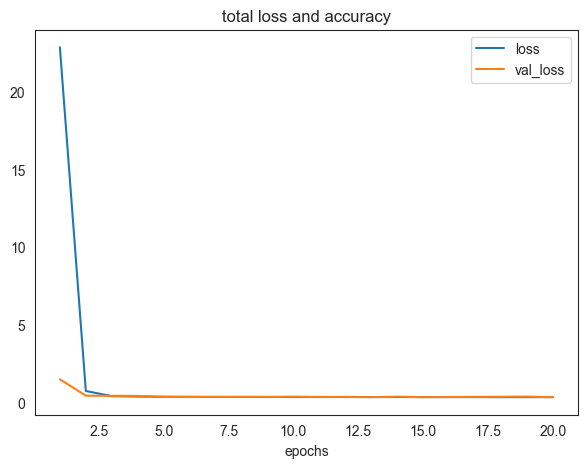

In [69]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 764us/step
TRAIN Root Mean Squared Error(RMSE): 0.5793474569226238
TEST Root Mean Squared Error(RMSE): 0.5865558217744432
ALL RMSE: 0.5814342312010974


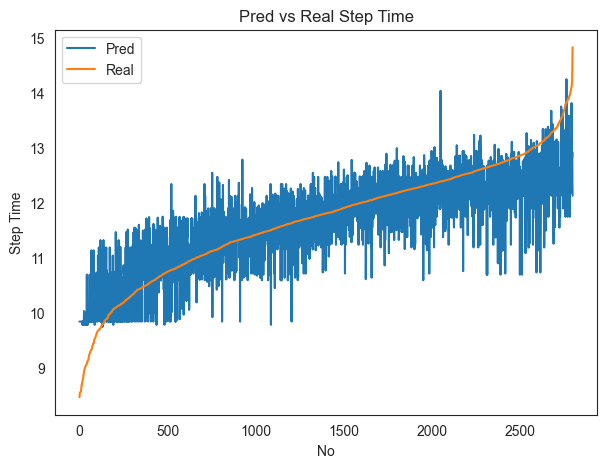

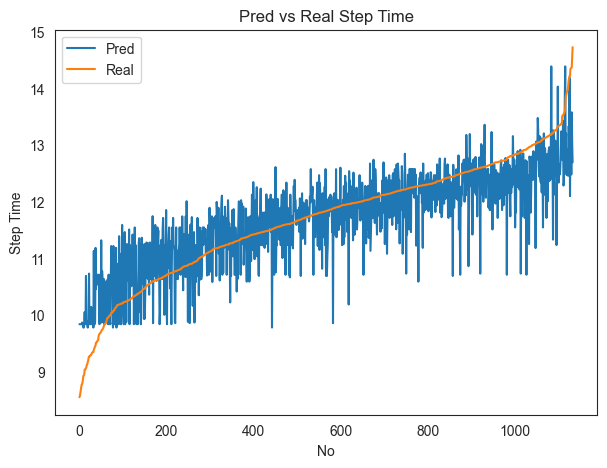

In [70]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# Square ABS Data + Yeo-Johnson Norm

array([[<AxesSubplot: title={'center': 'vertices_dif'}>,
        <AxesSubplot: title={'center': 'redexes_dif'}>],
       [<AxesSubplot: title={'center': 'heights_dif'}>,
        <AxesSubplot: title={'center': 'widths_dif'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'steps_time'}>]], dtype=object)

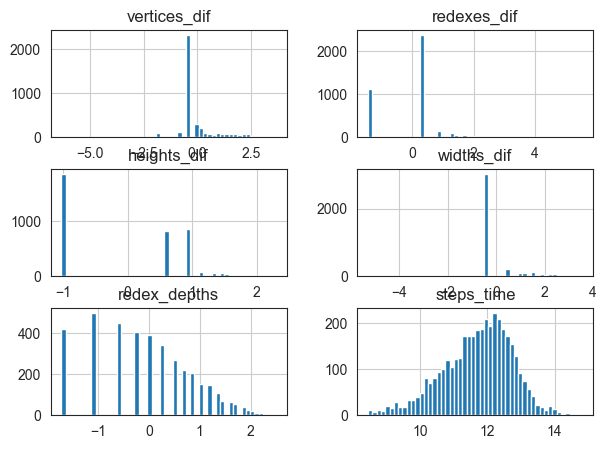

In [71]:
data_bc = pd.DataFrame()
power_trans = PowerTransformer(method='yeo-johnson')

for col_name in ['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif',
                 'redex_depths']:
    norm_col_data = np.array(np.sqrt(np.abs(data[col_name])))
    norm_col_data = power_trans.fit_transform(norm_col_data.reshape(-1, 1))
    data_bc[col_name] = list(norm_col_data.reshape(1, -1)[0])

data_bc['steps_time'] = np.log(data['steps_time'])

data_bc.hist(bins=50)

In [72]:
data_for_training = data_bc


def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")
x_train, y_train = train_ds.drop('steps_time', axis=1), train_ds[["steps_time"]]
x_test, y_test = test_ds.drop('steps_time', axis=1), test_ds[["steps_time"]]
x_data, y_data = data_for_training.drop('steps_time', axis=1), data_for_training[["steps_time"]]

Examples for training 2750
Examples for testing 1181


## 1. Linear Regression

TRAIN Root Mean Squared Error(RMSE): 0.6314230887840557
TEST Root Mean Squared Error(RMSE): 0.6165153988797457


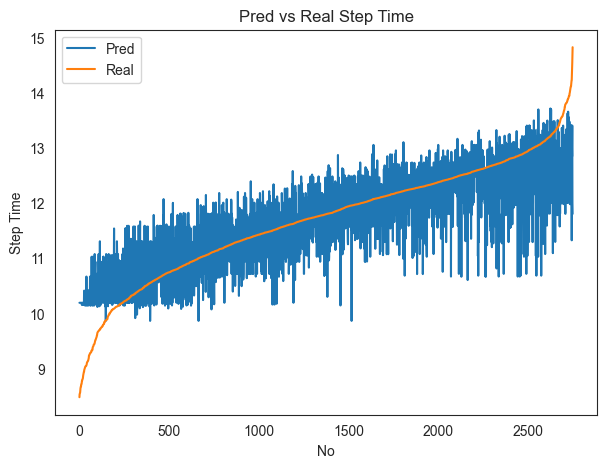

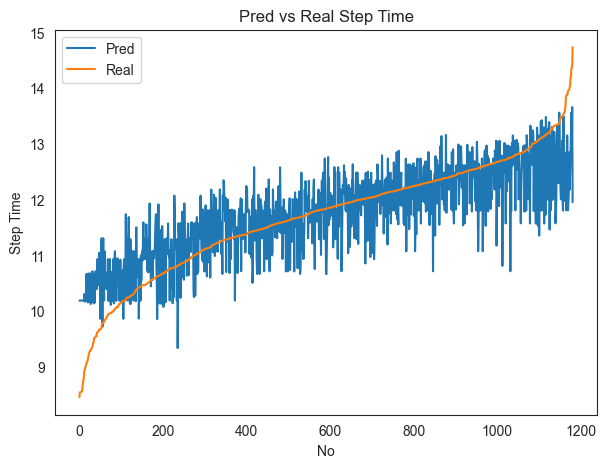

In [76]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

ALL RMSE: 0.6265987895091604


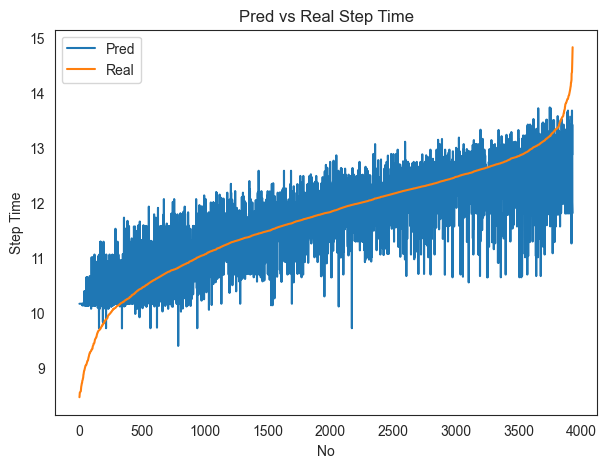

In [77]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

## 2. ANN Regression

In [73]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2750/2750 [==============================] - 4s 1ms/step - loss: 25.9723 - val_loss: 3.0616
Epoch 2/20
2750/2750 [==============================] - 3s 1ms/step - loss: 1.3787 - val_loss: 0.8075
Epoch 3/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.5521 - val_loss: 0.4160
Epoch 4/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.4361 - val_loss: 0.3711
Epoch 5/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.3949 - val_loss: 0.3428
Epoch 6/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.3805 - val_loss: 0.3393
Epoch 7/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.3705 - val_loss: 0.3599
Epoch 8/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.3634 - val_loss: 0.3276
Epoch 9/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.3625 - val_loss: 0.3403
Epoch 10/20
2750/2750 [==============================] - 3s 1ms/step - loss: 0.36

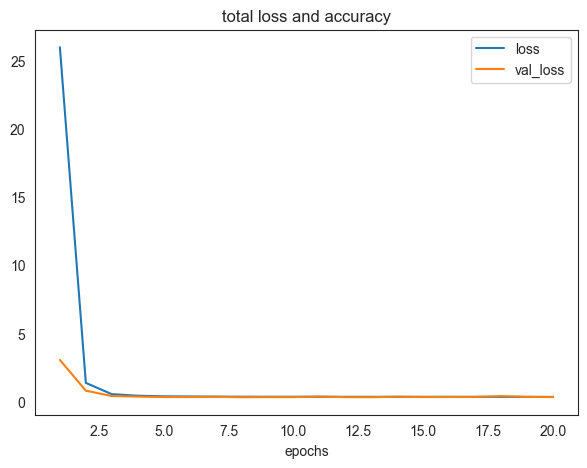

In [74]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 751us/step
TRAIN Root Mean Squared Error(RMSE): 0.5960814963018018
TEST Root Mean Squared Error(RMSE): 0.5819739366668395
ALL RMSE: 0.5918784695396114


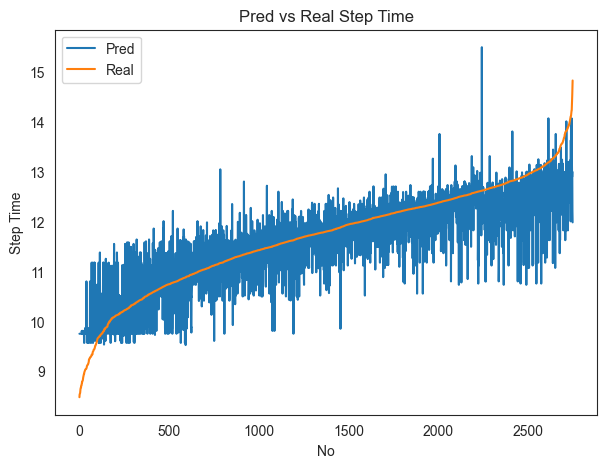

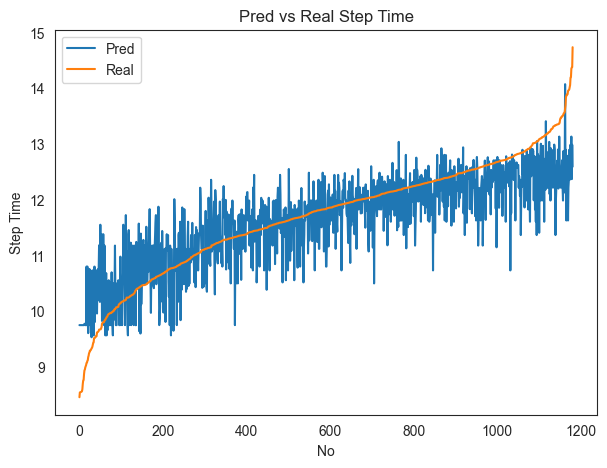

In [75]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())